# Hotels and Restaurants Reviews Analysis and Generation

## Table of Contents
1. [Import Libraries](#import-libraries)
2. [Import Dataset](#import-dataset)
3. [Data Analysis and Cleaning](#data-analysis-and-cleaning)
4. [Model Training and Implementation](#model-training-and-implementation)
    - [Grading Model](#grading-model)
    - [Review Generation Model](#review-generation-model)
5. [Building the Goal Functions](#building-the-goal-functions)
    - [Function to Grade a Review](#function-to-grade-a-review)
    - [Function to Generate a Review](#function-to-generate-a-review)
6. [Optional: Building a GUI with Flask and Ngrok](#optional-building-a-gui-with-flask-and-ngrok)

---


In [1]:
!pip install transformers
!pip install flask
!pip install flask_ngrok
!pip install pyngrok
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install re
!pip install string
!pip install collections
!pip install sklearn
!pip install torch
!pip install tqdm
!pip install torchvision
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
ERROR: Could not fi

## Import Libraries

First, we'll import all the necessary libraries required for data manipulation, visualization, NLP processing, model training, and building the web interface.

In [2]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

# NLP libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from collections import Counter

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Hugging Face Transformers for BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, ProgressCallback
# PyTorch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

# Flask for web app
from flask import Flask, request, jsonify

from flask_ngrok import run_with_ngrok

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')

/Users/Gabriel/Library/Caches/pypoetry/virtualenvs/reviews-nlp-TO1qKy9D-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/Gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---

## Import Dataset

Assuming you have the `review.csv` file uploaded to your Google Colab environment, we'll load the dataset using Pandas.

In [4]:
# Load the dataset
df = pd.read_csv('reviews.csv', delimiter=';')

# Display the first few rows
print("First 5 entries:")
display(df.head())

# Dataset information
print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

First 5 entries:


,restaurant_URL,Review,Rating
0,https://www.tripadvisor.com/Restaurant_Review-...,We arrived about ten minutes late for our rese...,5.0
1,https://www.tripadvisor.com/Restaurant_Review-...,We got a reservation at Septime a couple of mo...,5.0
2,https://www.tripadvisor.com/Restaurant_Review-...,"I’m really torn about this review. First, my w...",3.0
3,https://www.tripadvisor.com/Restaurant_Review-...,Really an underwhelming experience. The effort...,2.0
4,https://www.tripadvisor.com/Restaurant_Review-...,After reading earlier reviews and articles on ...,2.0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187618 entries, 0 to 187617
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   restaurant_URL  187618 non-null  object 
 1   Review          187618 non-null  object 
 2   Rating          187618 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.3+ MB
None

Missing Values:
restaurant_URL    0
Review            0
Rating            0
dtype: int64


---

## Data Analysis and Cleaning

### Exploratory Data Analysis (EDA)

Let's explore the distribution of ratings and the general sentiment of reviews.

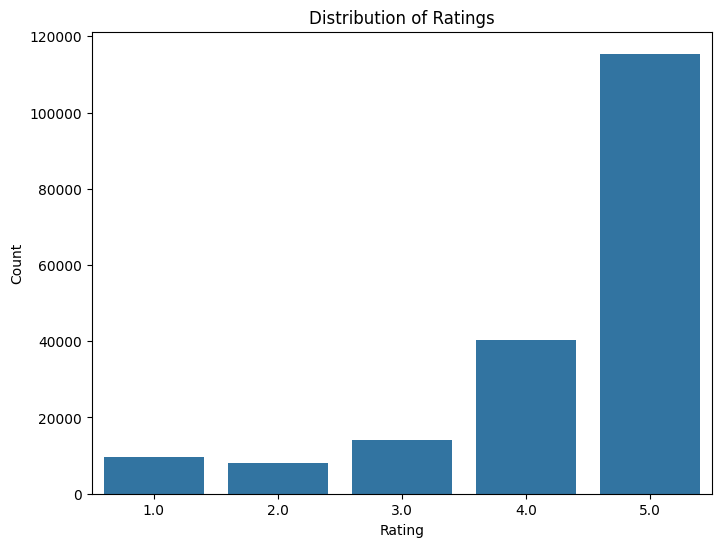

Average Rating: 4.30


In [5]:
# Distribution of Ratings
plt.figure(figsize=(8,6))
sns.countplot(x='Rating', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Average Rating
average_rating = df['Rating'].mean()
print(f"Average Rating: {average_rating:.2f}")

In [6]:
df['review_length'] = df['Review'].apply(len)

# Review Length Distribution
print(f"Average review length: {df['review_length'].mean():.2f} characters")
print(f"Median review length: {df['review_length'].median()} characters")
print(f"Shortest review: {df['review_length'].min()} characters")
print(f"Longest review: {df['review_length'].max()} characters")

Average review length: 419.58 characters
Median review length: 307.0 characters
Shortest review: 4 characters
Longest review: 9041 characters


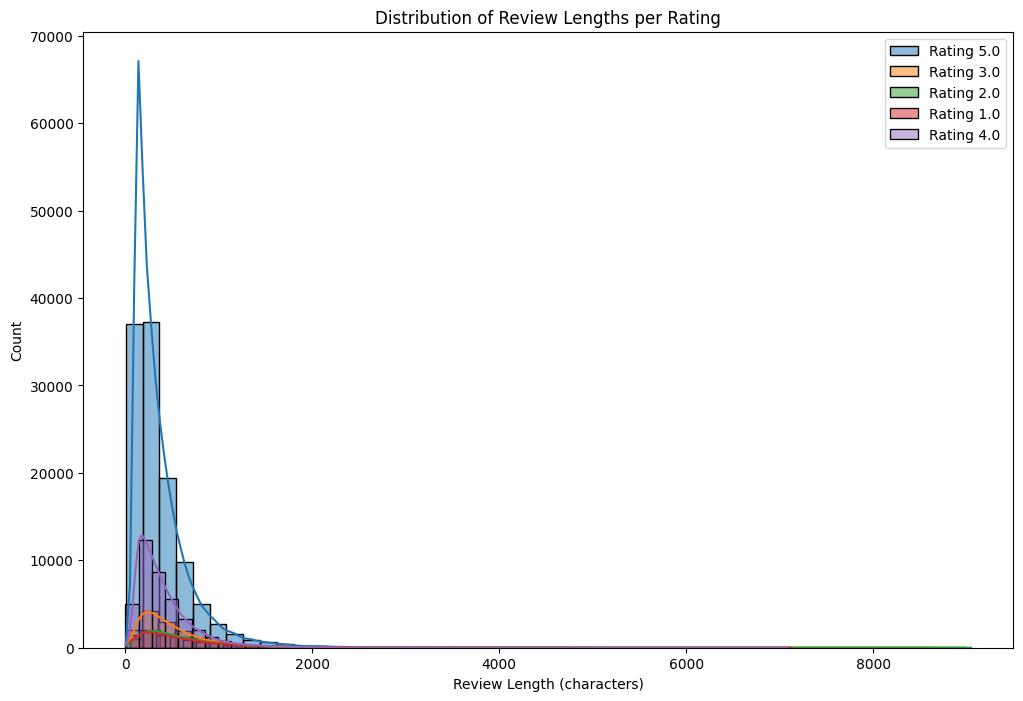

In [7]:
# Review Length Distribution per Rating
plt.figure(figsize=(12, 8))
for rating in df['Rating'].unique():
    sns.histplot(data=df[df['Rating'] == rating], x='review_length', bins=50, kde=True, label=f'Rating {rating}')
plt.title('Distribution of Review Lengths per Rating')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.legend()

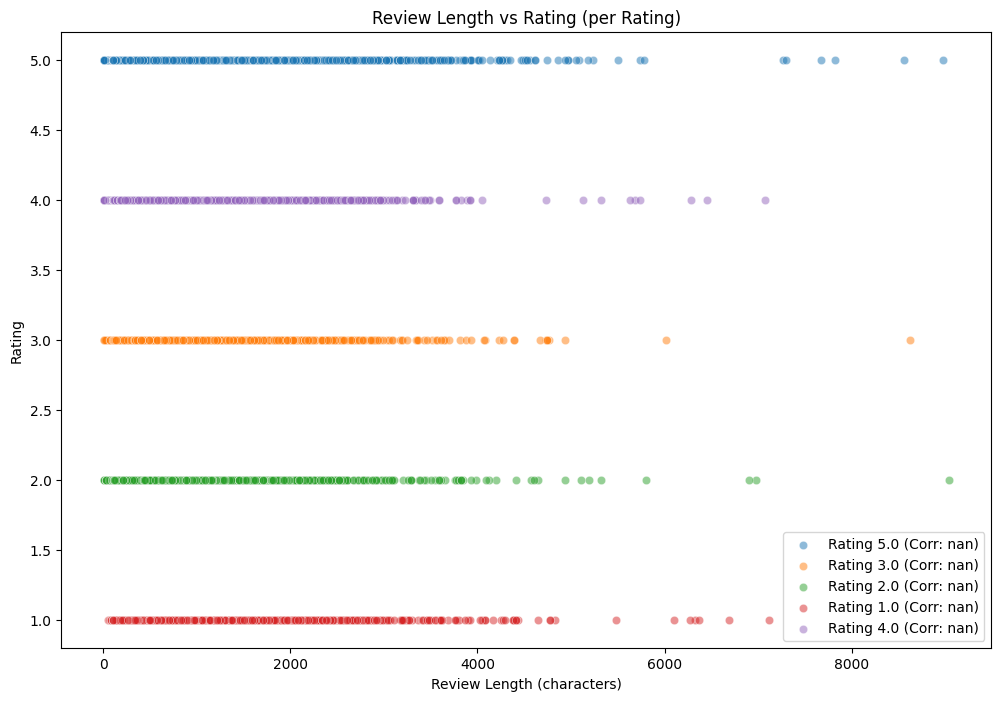

Overall correlation between Review Length and Rating: -0.21


In [8]:
# Correlation between Review Length and Rating for each Rating
plt.figure(figsize=(12, 8))
for rating in df['Rating'].unique():
    subset = df[df['Rating'] == rating]
    correlation = subset['review_length'].corr(subset['Rating'])
    sns.scatterplot(data=subset, x='review_length', y='Rating',
                    label=f'Rating {rating} (Corr: {correlation:.2f})', alpha=0.5)

plt.title('Review Length vs Rating (per Rating)')
plt.xlabel('Review Length (characters)')
plt.ylabel('Rating')
plt.legend()
plt.show()

# Print overall correlation
overall_correlation = df['review_length'].corr(df['Rating'])
print(f"Overall correlation between Review Length and Rating: {overall_correlation:.2f}")

In [9]:
# Show reviews with less than 10 characters
short_reviews = df[df['Review'].str.len() < 10]
print("Reviews with less than 10 characters:")
print(short_reviews[['Review', 'Rating']])
print(f"\nNumber of reviews with less than 10 characters: {len(short_reviews)}")


Reviews with less than 10 characters:
           Review  Rating
37804        Cute     4.0
42203     Great!!     4.0
91806    Original     4.0
100769  一個字::正 :]     5.0
118492  Expensive     4.0
128273   divinooo     5.0
131213       good     4.0
131260  Best ever     5.0
185916     good !     4.0
185917   superbe!     5.0
185918  i love it     5.0
185920  i love it     5.0

Number of reviews with less than 10 characters: 12


### Data Cleaning

We'll perform the following cleaning steps:
- Remove duplicates
- Handle missing values
- Text preprocessing: lowercasing, removing punctuation, removing stopwords

In [10]:
# Remove duplicates and handle missing values
initial_shape = df.shape[0]
df.drop_duplicates(inplace=True)
df.dropna(subset=['Review', 'Rating'], inplace=True)
final_shape = df.shape[0]

print(f"Removed {initial_shape - final_shape} duplicate or missing entries.")
print(f"Dataset shape after cleaning: {df.shape}")

Removed 11078 duplicate or missing entries.
Dataset shape after cleaning: (176540, 4)


In [12]:
# Text Preprocessing Functions
def clean_text(text):
    text = text.lower()
    # Remove URLs, numbers, punctuation and special characters in one pass
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]|<.*?>+|\n|\w*\d\w*|[^\w\s]', '', text)
    return text

def text_preprocessing(text):
    cleaned_text = clean_text(text)
    tokens = cleaned_text.split()
    stop_words = set(stopwords.words('english'))
    tokens_without_stopwords = [w for w in tokens if w not in stop_words]
    return tokens_without_stopwords

# Apply preprocessing with progress bar and vectorized operations
df['Cleaned_Review'] = df['Review'].progress_apply(text_preprocessing)

100%|██████████| 176540/176540 [00:16<00:00, 10862.11it/s]


In [13]:
# Display sample cleaned reviews
print("\nSample Cleaned Reviews:")
display(df[['Review', 'Cleaned_Review']].head())


Sample Cleaned Reviews:


,Review,Cleaned_Review
0,We arrived about ten minutes late for our rese...,"[arrived, ten, minutes, late, reservation, rec..."
1,We got a reservation at Septime a couple of mo...,"[got, reservation, septime, couple, months, co..."
2,"I’m really torn about this review. First, my w...","[im, really, torn, review, first, wife, stayed..."
3,Really an underwhelming experience. The effort...,"[really, underwhelming, experience, effort, go..."
4,After reading earlier reviews and articles on ...,"[reading, earlier, reviews, articles, restaura..."


Top 20 most common words:
food: 109358
good: 91377
restaurant: 82257
service: 78281
paris: 67032
great: 61887
place: 58943
us: 45850
wine: 40451
menu: 39047
staff: 38919
french: 38482
one: 37478
excellent: 36230
friendly: 35342
nice: 34952
delicious: 33997
would: 33823
time: 32627
meal: 31534


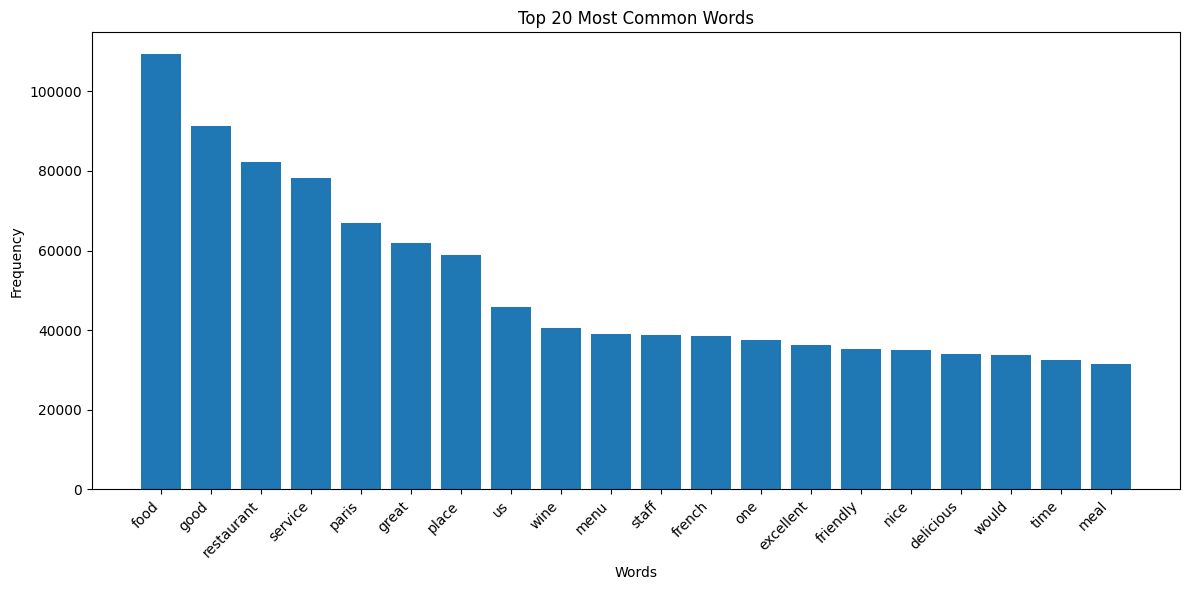

In [14]:
# Flatten the list of lists in 'Cleaned_Review' column
all_words = [word for review in df['Cleaned_Review'] for word in review]

# Count words
word_counts = Counter(all_words)

# Display top 20 most common words
print("Top 20 most common words:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")

top_20_words = dict(word_counts.most_common(20))
plt.figure(figsize=(12, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [15]:
# Save the cleaned dataset
df.to_csv('cleaned_reviews.csv', index=False, sep=';')
print(df.describe())
print(df.info())

              Rating  review_length
count  176540.000000  176540.000000
mean        4.297757     421.171910
std         1.112091     378.223661
min         1.000000       4.000000
25%         4.000000     180.000000
50%         5.000000     308.000000
75%         5.000000     527.000000
max         5.000000    9041.000000
<class 'pandas.core.frame.DataFrame'>
Index: 176540 entries, 0 to 187617
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   restaurant_URL  176540 non-null  object 
 1   Review          176540 non-null  object 
 2   Rating          176540 non-null  float64
 3   review_length   176540 non-null  int64  
 4   Cleaned_Review  176540 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.1+ MB
None


In [18]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_reviews.csv', delimiter=';')
print(df.describe())
print(df.info())

              Rating  review_length
count  176540.000000  176540.000000
mean        4.297757     421.171910
std         1.112091     378.223661
min         1.000000       4.000000
25%         4.000000     180.000000
50%         5.000000     308.000000
75%         5.000000     527.000000
max         5.000000    9041.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176540 entries, 0 to 176539
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   restaurant_URL  176540 non-null  object 
 1   Review          176540 non-null  object 
 2   Rating          176540 non-null  float64
 3   review_length   176540 non-null  int64  
 4   Cleaned_Review  176540 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.7+ MB
None


---

## Model Training and Implementation

We'll build two models:
1. **Grading Model**: Predicts the rating (0-5) based on the review text.
2. **Review Generation Model**: Generates a review based on a given rating and keywords.

### Grading Model

We'll use BERT for sequence classification to predict the rating.

In [19]:
# Define number of classes (ratings 0-5)
df['Rating'] = df['Rating'].astype(np.float32)
num_labels = df['Rating'].nunique()

# Split the dataset
X = df['Cleaned_Review'].tolist()
y = df['Rating'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_test)}")

Training samples: 141232
Validation samples: 35308


#### Tokenization

In [20]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(texts, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

print("Tokenizing training data...")
train_encodings = tokenize(X_train)

print("Tokenizing test data...")
test_encodings = tokenize(X_test)


Tokenizing training data...
Tokenizing test data...


#### Create PyTorch Datasets

In [21]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewsDataset(train_encodings, y_train)
test_dataset = ReviewsDataset(test_encodings, y_test)

In [41]:
len(train_dataset.__dict__.get('encodings').get('input_ids'))

141232

In [22]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Initialize BERT for Sequence Classification

In [23]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using MPS device


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import time
import torch

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Define training parameters
epochs = 3
total_steps = len(train_loader) * epochs

# Initialize the scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the model to training mode
model.train()

# Initialize a single tqdm progress bar for all epochs and batches
progress_bar = tqdm(
    range(epochs * len(train_loader)),
    desc="Training",
    unit="batch",
    ascii=True  # Force ASCII characters if needed
)

for epoch in range(epochs):
    epoch_loss = 0
    start_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader, 1):
        optimizer.zero_grad()

        # Move inputs to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        scheduler.step()

        # Update the progress bar with current loss
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        progress_bar.update(1)

        # Optionally, log every 100 batches
        if (batch_idx) % 100 == 0:
            tqdm.write(f'Epoch {epoch + 1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}')

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    end_time = time.time()
    epoch_time = end_time - start_time

    # Log epoch summary
    tqdm.write(f'Epoch {epoch + 1}/{epochs} completed in {epoch_time:.2f} seconds')
    tqdm.write(f'Average training loss: {avg_loss:.4f}')

print("Training complete!")

#### Training Arguments & Torch Trainer

In [49]:
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
torch.set_default_dtype(torch.float32)

In [58]:
# Update TrainingArguments to include evaluation strategy
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Set higher epochs; early stopping will handle stopping
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [59]:
# Initialize Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 evaluations
)

# Start Training
print("Starting training with early stopping...")
trainer.train()
print("Training completed.")


Starting training with early stopping...


  0%|          | 10/88270 [00:14<29:09:58,  1.19s/it]



                                                                              


  0%|          | 10/88270 [00:14<29:09:58,  1.19s/it]

{'loss': 0.4049, 'grad_norm': 4.513328552246094, 'learning_rate': 4.999433556134587e-05, 'epoch': 0.0}


  0%|          | 20/88270 [00:26<28:11:03,  1.15s/it]



                                                                                


  0%|          | 20/88270 [00:26<28:11:03,  1.15s/it]

{'loss': 0.3519, 'grad_norm': 2.4810872077941895, 'learning_rate': 4.9988671122691745e-05, 'epoch': 0.0}


  0%|          | 30/88270 [00:37<28:19:24,  1.16s/it]



                                                                                


  0%|          | 30/88270 [00:37<28:19:24,  1.16s/it]

{'loss': 0.3383, 'grad_norm': 3.843733787536621, 'learning_rate': 4.998300668403761e-05, 'epoch': 0.0}


  0%|          | 40/88270 [00:49<28:04:24,  1.15s/it]



                                                                                


  0%|          | 40/88270 [00:49<28:04:24,  1.15s/it]

{'loss': 0.4499, 'grad_norm': 2.7511448860168457, 'learning_rate': 4.997734224538349e-05, 'epoch': 0.0}


  0%|          | 50/88270 [01:01<28:03:42,  1.15s/it]



                                                                                


  0%|          | 50/88270 [01:01<28:03:42,  1.15s/it]

{'loss': 0.2849, 'grad_norm': 2.8501996994018555, 'learning_rate': 4.9971677806729356e-05, 'epoch': 0.01}


  0%|          | 60/88270 [01:12<28:50:11,  1.18s/it]



                                                                                


  0%|          | 60/88270 [01:12<28:50:11,  1.18s/it]

{'loss': 0.3538, 'grad_norm': 3.2741401195526123, 'learning_rate': 4.9966013368075224e-05, 'epoch': 0.01}


  0%|          | 70/88270 [01:24<28:36:58,  1.17s/it]



                                                                                


  0%|          | 70/88270 [01:24<28:36:58,  1.17s/it]

{'loss': 0.3024, 'grad_norm': 4.949029445648193, 'learning_rate': 4.99603489294211e-05, 'epoch': 0.01}


  0%|          | 80/88270 [01:35<28:04:05,  1.15s/it]



                                                                                


  0%|          | 80/88270 [01:36<28:04:05,  1.15s/it]

{'loss': 0.3323, 'grad_norm': 1.8468499183654785, 'learning_rate': 4.995468449076697e-05, 'epoch': 0.01}


  0%|          | 90/88270 [01:47<27:59:51,  1.14s/it]



                                                                                


  0%|          | 90/88270 [01:47<27:59:51,  1.14s/it]

{'loss': 0.2924, 'grad_norm': 2.945129632949829, 'learning_rate': 4.9949020052112835e-05, 'epoch': 0.01}


  0%|          | 100/88270 [01:58<27:57:37,  1.14s/it]



                                                                                


  0%|          | 100/88270 [01:58<27:57:37,  1.14s/it]

{'loss': 0.3656, 'grad_norm': 2.5911660194396973, 'learning_rate': 4.994335561345871e-05, 'epoch': 0.01}


  0%|          | 110/88270 [02:10<28:59:18,  1.18s/it]



                                                                                


  0%|          | 110/88270 [02:10<28:59:18,  1.18s/it]

{'loss': 0.2714, 'grad_norm': 6.133207321166992, 'learning_rate': 4.993769117480458e-05, 'epoch': 0.01}


  0%|          | 120/88270 [02:27<43:09:03,  1.76s/it]



                                                                                


  0%|          | 120/88270 [02:28<43:09:03,  1.76s/it]

{'loss': 0.2387, 'grad_norm': 8.096701622009277, 'learning_rate': 4.993202673615045e-05, 'epoch': 0.01}


  0%|          | 130/88270 [02:44<41:24:02,  1.69s/it]



                                                                                


  0%|          | 130/88270 [02:44<41:24:02,  1.69s/it]

{'loss': 0.3033, 'grad_norm': 2.563068151473999, 'learning_rate': 4.992636229749632e-05, 'epoch': 0.01}


  0%|          | 140/88270 [03:03<44:43:33,  1.83s/it]



                                                                                


  0%|          | 140/88270 [03:03<44:43:33,  1.83s/it]

{'loss': 0.3745, 'grad_norm': 14.276996612548828, 'learning_rate': 4.992069785884219e-05, 'epoch': 0.02}


  0%|          | 150/88270 [03:20<40:41:40,  1.66s/it]



                                                                                


  0%|          | 150/88270 [03:20<40:41:40,  1.66s/it]

{'loss': 0.2897, 'grad_norm': 5.627524375915527, 'learning_rate': 4.9915033420188064e-05, 'epoch': 0.02}


  0%|          | 160/88270 [03:35<38:00:59,  1.55s/it]



                                                                                


  0%|          | 160/88270 [03:35<38:00:59,  1.55s/it]

{'loss': 0.3156, 'grad_norm': 3.219870090484619, 'learning_rate': 4.990936898153393e-05, 'epoch': 0.02}


  0%|          | 170/88270 [03:50<37:30:16,  1.53s/it]



                                                                                


  0%|          | 170/88270 [03:50<37:30:16,  1.53s/it]

{'loss': 0.3777, 'grad_norm': 10.489309310913086, 'learning_rate': 4.9903704542879807e-05, 'epoch': 0.02}


  0%|          | 180/88270 [04:05<36:27:59,  1.49s/it]



                                                                                


  0%|          | 180/88270 [04:05<36:27:59,  1.49s/it]

{'loss': 0.3691, 'grad_norm': 5.539361953735352, 'learning_rate': 4.9898040104225675e-05, 'epoch': 0.02}


  0%|          | 184/88270 [04:12<43:39:32,  1.78s/it]

KeyboardInterrupt: 

#### Evaluation

In [ ]:
# Evaluate the model
eval_result = trainer.evaluate()
print(f"Validation Loss: {eval_result['eval_loss']}")

In [ ]:
# Extract training loss from trainer's state
train_loss = trainer.state.log_history

# Extract epoch and loss values
epochs = [log['epoch'] for log in train_loss if 'loss' in log]
losses = [log['loss'] for log in train_loss if 'loss' in log]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Print final loss
print(f"Final training loss: {losses[-1]:.4f}")


In [ ]:
# Save the trained model and tokenizer
model.save_pretrained("review_grader")
tokenizer.save_pretrained("review_grader")
print("Model saved to 'review_grader' directory.")

In [ ]:
# Load the saved model and tokenizer for inference

loaded_tokenizer = BertTokenizer.from_pretrained("graded_model")
loaded_model = BertForSequenceClassification.from_pretrained("graded_model")
loaded_model.to(device)
print("Model and tokenizer loaded successfully for inference.")

### Review Generation Model

For generating reviews based on a given grade and keywords, we'll use BERT's conditional generation capabilities. However, BERT is primarily for understanding tasks. For generation, models like GPT-2 are more suitable. Here, we'll use GPT-2.

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize GPT-2 tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

# Fine-tuning GPT-2 is resource-intensive and may not be feasible in Colab.
# Instead, we'll use prompt engineering for demonstration purposes.

---

## Building the Goal Functions

### Function to Grade a Review

This function takes a review string as input and returns a predicted rating between 0 and 5.

In [ ]:
def grade(review: str) -> float:
    # Preprocess the review
    cleaned_review = preprocess_text(review)
    # Tokenize
    encoding = tokenizer(cleaned_review, truncation=True, padding=True, max_length=128, return_tensors='pt')
    # Get model predictions
    with torch.no_grad():
        outputs = model(**encoding)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    # Convert back to original rating scale
    return predicted_class + 1

**Usage Example:**

In [ ]:
sample_review = "The food was amazing and the staff was very friendly!"
predicted_rating = grade(sample_review)
print(f"Predicted Rating: {predicted_rating}")

### Function to Generate a Review

This function generates a review based on a given grade and a list of keywords. We'll use GPT-2 with prompt engineering.

In [ ]:
def gen_review(grade: float, keywords: list) -> str:
    # Create a prompt based on grade and keywords
    keywords_str = ', '.join(keywords)
    prompt = f"Generate a restaurant review with a rating of {grade} stars. Keywords: {keywords_str}. Review:"

    # Encode the prompt
    input_ids = gpt2_tokenizer.encode(prompt, return_tensors='pt')

    # Generate text
    output = gpt2_model.generate(
        input_ids,
        max_length=150,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        early_stopping=True
    )

    # Decode the generated text
    generated_review = gpt2_tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract the review part
    review = generated_review.split("Review:")[-1].strip()

    return review

**Usage Example:**

In [ ]:
desired_grade = 5
keywords = ["excellent service", "delicious food", "cozy atmosphere"]
generated_review = gen_review(desired_grade, keywords)
print(f"Generated Review:\n{generated_review}")

---

## Optional: Building a GUI with Flask and Ngrok

We'll create a simple web interface where users can input a review to get a grade and generate a review based on a grade and keywords.

In [ ]:
# Initialize Flask app
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/')
def home():
    return """
    <h1>Hotel and Restaurant Review Analyzer and Generator</h1>
    <h2>Grade a Review</h2>
    <form action="/grade" method="post">
        <textarea name="review" rows="4" cols="50" placeholder="Enter your review here..."></textarea><br>
        <input type="submit" value="Grade Review">
    </form>
    <h2>Generate a Review</h2>
    <form action="/generate" method="post">
        <input type="number" name="grade" step="0.1" min="0" max="5" placeholder="Enter desired grade (0-5)"><br>
        <input type="text" name="keywords" placeholder="Enter keywords, separated by commas"><br>
        <input type="submit" value="Generate Review">
    </form>
    """

@app.route('/grade', methods=['POST'])
def grade_review():
    review = request.form['review']
    predicted_rating = grade(review)
    return f"<h3>Predicted Rating: {predicted_rating}</h3><a href='/'>Go Back</a>"

@app.route('/generate', methods=['POST'])
def generate_review():
    grade_input = request.form['grade']
    keywords_input = request.form['keywords']
    try:
        grade_float = float(grade_input)
        if not (0 <= grade_float <= 5):
            raise ValueError
    except ValueError:
        return "<h3>Invalid grade input. Please enter a number between 0 and 5.</h3><a href='/'>Go Back</a>"

    keywords_list = [kw.strip() for kw in keywords_input.split(',') if kw.strip()]
    if not keywords_list:
        return "<h3>Please provide at least one keyword.</h3><a href='/'>Go Back</a>"

    generated = gen_review(grade_float, keywords_list)
    return f"<h3>Generated Review:</h3><p>{generated}</p><a href='/'>Go Back</a>"

if __name__ == '__main__':
    app.run()

**Instructions to Run the Flask App:**
1. Ensure all the above cells are executed in your Colab notebook.
2. Run the Flask app cell. It will provide a public URL via Ngrok.
3. Click on the provided Ngrok URL to access the web interface.

---

# Conclusion

This notebook provides a complete pipeline for analyzing and generating hotel and restaurant reviews using NLP techniques. The grading model leverages BERT for accurate rating predictions, while the review generation leverages GPT-2 for creating coherent and contextually relevant reviews based on user inputs. The optional Flask web interface allows for easy interaction with the models.

**Note:**
- Fine-tuning large models like BERT and GPT-2 can be resource-intensive. Ensure that your environment (e.g., Google Colab) has sufficient resources, and consider using GPU acceleration.
- For production-level applications, additional considerations like model optimization, security, and scalability should be addressed.

Feel free to customize and enhance the models and interfaces based on your specific project requirements!